# Hyper-parameter Optimization, Model Validation and Permutation Importance II (Working Notebook) 

The following models in this notebook are only fitted onto the **dps1200** dataset provided by Bernhard Spangl. This data contains smoothed FTIR spectral data measured from *pinus silvestris* wooden samples.

The data was cleaned with the R-file dataPSsub_new3.Rnw

The ML models used are:

- Random Forest Regression (RF)
- Support Vector Regression (SVR)

## Loading of data

In [3]:
import pandas as pd
import numpy as np

# set random seed
np.random.seed(42)

# Load data from csv file
data_ftir = pd.read_csv('dps1200.csv')

# Rename columns to remove leading 'X'
data_ftir.columns = [col.replace('X', '') for col in data_ftir.columns]

print(data_ftir.head())

     Unnamed: 0  year     tree Origin    type      2970      2968      2966  \
0  2GOS-18_1955  1955  2GOS-18    POL  living  0.019849  0.020121  0.020414   
1  2GOS-18_1969  1969  2GOS-18    POL  living  0.023933  0.024378  0.024827   
2  2GOS-18_1974  1974  2GOS-18    POL  living  0.021605  0.021971  0.022342   
3  2GOS-18_1976  1976  2GOS-18    POL  living  0.021999  0.022315  0.022651   
4  2GOS-18_1996  1996  2GOS-18    POL  living  0.021031  0.021338  0.021626   

       2964      2962  ...       818       816       814       812       810  \
0  0.020724  0.021030  ... -0.023469 -0.023367 -0.023283 -0.023220 -0.023183   
1  0.025273  0.025712  ... -0.024117 -0.024076 -0.024043 -0.024021 -0.024015   
2  0.022719  0.023099  ... -0.026266 -0.026214 -0.026172 -0.026149 -0.026146   
3  0.022999  0.023345  ... -0.025113 -0.025030 -0.024959 -0.024909 -0.024885   
4  0.021923  0.022248  ... -0.025256 -0.025158 -0.025083 -0.025035 -0.025013   

        808       806       804       802   

## Data preparation

### Visualization of target variable

Text(0, 0.5, 'counts')

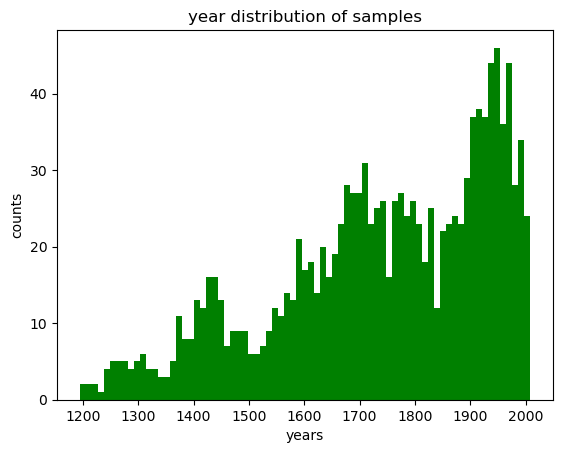

In [4]:
from matplotlib import pyplot as plt

# histogram of year distribution
plt.hist(data_ftir['year'], bins= 75, color= "green")
plt.title("year distribution of samples")
plt.xlabel("years")
plt.ylabel("counts")

### Minimum and maximum value of target variable

In [5]:
data_ftir['year'].agg(['min', 'max'])

min    1194
max    2009
Name: year, dtype: int64

This figure above shows that the younger samples are over-represented (1900 to 2000). Would be an option to add a column to the initial dataset implementing a category variable of all the samples in a century. 

Categories:
- 1 (1150 - 1400)
- 2 (1401 - 1600)
- 3 (1601 - 1800)
- 4 (1801 - 2010)

In [6]:
from copy import deepcopy
data = deepcopy(data_ftir)

def categorize_years(year):
    """
    Categorizes a given year into one of four historical periods.

    Parameters:
    year (int): The year to be categorized.

    Returns:
    int: A numerical category representing the period the year falls into:
         - 1: 1150 to 1400
         - 2: 1401 to 1600
         - 3: 1601 to 1800
         - 4: 1801 to 2010

    Notes:
    - The minimum and maximum year boundaries have been adjusted to start from 1150 and end at 2010, respectively.
    """
    if 1150 <= year <= 1400: # adjustment because of min value
        return 1
    elif 1401 <= year <= 1600:
        return 2
    elif 1601 <= year <= 1800:
        return 3
    elif 1801 <= year <= 2010: # agjustment because of max value
        return 4 

# Should generate age categories which can be used from StratifiedShuffleSplit while splitting the data the train and the test set.  

data["category"] = data["year"].apply(categorize_years)

print(data)

         Unnamed: 0  year      tree Origin    type      2970      2968  \
0      2GOS-18_1955  1955   2GOS-18    POL  living  0.019849  0.020121   
1      2GOS-18_1969  1969   2GOS-18    POL  living  0.023933  0.024378   
2      2GOS-18_1974  1974   2GOS-18    POL  living  0.021605  0.021971   
3      2GOS-18_1976  1976   2GOS-18    POL  living  0.021999  0.022315   
4      2GOS-18_1996  1996   2GOS-18    POL  living  0.021031  0.021338   
...             ...   ...       ...    ...     ...       ...       ...   
1285  SZLPS15a_1942  1942  SZLPS15a    AUT  living  0.018254  0.018577   
1286  SZLPS15a_1952  1952  SZLPS15a    AUT  living  0.018508  0.018778   
1287  SZLPS15a_1962  1962  SZLPS15a    AUT  living  0.017196  0.017486   
1288  SZLPS15a_1972  1972  SZLPS15a    AUT  living  0.017298  0.017541   
1289  SZLPS15a_1982  1982  SZLPS15a    AUT  living  0.017682  0.017931   

          2966      2964      2962  ...       816       814       812  \
0     0.020414  0.020724  0.021030  ..

### Separation of dataset into train and test set (using StratifiedShuffleSplit)

StratifiedShuffleSplit is a variation of ShuffleSplit, which returns stratified splits, i.e which creates splits by preserving the same percentage for each target class as in the complete set

The following code (splitting the data with StratifiedShuffleSplit and calculating the percentages of the categories) is based on the code from the book "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron.

Reference:
A. Géron, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, Second Edi., vol. 44, no. 8. O’Reilly Media Inc., 2019.

In [7]:
# credits to book "Hands-on-Maschine-Learning"!
from sklearn.model_selection import StratifiedShuffleSplit

# split data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(data, data["category"]):
    data_train_set = data.loc[train_index]
    data_test_set = data.loc[test_index]

In [8]:
data_test_set["category"].value_counts() / len(data_test_set)

category
4    0.445736
3    0.325581
2    0.162791
1    0.065891
Name: count, dtype: float64

"category" should be removed from the data to reach the original state again

In [9]:
for set_ in (data_train_set, data_test_set):
    set_.drop("category", axis=1, inplace = True)

print(data_train_set)

         Unnamed: 0  year      tree Origin    type      2970      2968  \
240   AMEPS07a_1652  1652  AMEPS07a    AUT  constr  0.017896  0.018174   
829      JMS8b_1744  1744     JMS8b    FIN  living  0.020504  0.020845   
1095  SMGPS26b_1799  1799  SMGPS26b    AUT  constr  0.016173  0.016424   
162       2TW5_1420  1420      2TW5    POL  constr  0.019769  0.020004   
871      KOM2a_1973  1973     KOM2a    FIN  living  0.019226  0.019595   
...             ...   ...       ...    ...     ...       ...       ...   
673   ENTPS06a_1923  1923  ENTPS06a    AUT  living  0.021337  0.021711   
452      Dev1b_1919  1919     Dev1b    NOR  living  0.022280  0.022727   
730   ENTPS13a_1940  1940  ENTPS13a    AUT  living  0.018669  0.018960   
822      JMS7a_1811  1811     JMS7a    FIN  living  0.020567  0.020800   
806      JMS4b_1967  1967     JMS4b    FIN  living  0.017825  0.018059   

          2966      2964      2962  ...       818       816       814  \
240   0.018460  0.018750  0.019048  ..

Length of train set:

In [10]:
len(data_train_set)

1032

Length of test set:

In [11]:
len(data_test_set)

258

### Removal of target variable

X and y (target variable) dataframes are separated. X has then only the important wavelengths left. 

#### Training Set

In [12]:
X_TRAIN = data_train_set.drop(['year', 'Unnamed: 0', 'tree', 'Origin', 'type'], axis=1) # remove target variable, remove everything else which is not FTIR related?
X_TRAIN

,2970,2968,2966,2964,2962,2960,2959,2957,2955,2953,...,818,816,814,812,810,808,806,804,802,800
240,0.017896,0.018174,0.018460,0.018750,0.019048,0.019365,0.019705,0.020062,0.020419,0.020762,...,-0.017298,-0.017117,-0.016959,-0.016827,-0.016733,-0.016683,-0.016673,-0.016700,-0.016764,-0.016858
829,0.020504,0.020845,0.021209,0.021587,0.021970,0.022364,0.022765,0.023165,0.023566,0.023970,...,-0.021322,-0.021186,-0.021061,-0.020954,-0.020873,-0.020818,-0.020788,-0.020781,-0.020791,-0.020816
1095,0.016173,0.016424,0.016687,0.016963,0.017248,0.017536,0.017831,0.018146,0.018487,0.018843,...,-0.017067,-0.016910,-0.016772,-0.016658,-0.016573,-0.016521,-0.016502,-0.016516,-0.016557,-0.016626
162,0.019769,0.020004,0.020241,0.020488,0.020737,0.020980,0.021224,0.021484,0.021771,0.022087,...,-0.021572,-0.021392,-0.021244,-0.021130,-0.021045,-0.020989,-0.020974,-0.021009,-0.021090,-0.021201
871,0.019226,0.019595,0.019964,0.020336,0.020727,0.021140,0.021560,0.021973,0.022382,0.022796,...,-0.023450,-0.023339,-0.023232,-0.023138,-0.023069,-0.023030,-0.023019,-0.023033,-0.023074,-0.023145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,0.021337,0.021711,0.022062,0.022398,0.022724,0.023049,0.023374,0.023697,0.024017,0.024330,...,-0.018843,-0.018711,-0.018586,-0.018473,-0.018385,-0.018324,-0.018293,-0.018294,-0.018332,-0.018399
452,0.022280,0.022727,0.023193,0.023665,0.024133,0.024594,0.025051,0.025512,0.025988,0.026483,...,-0.024635,-0.024617,-0.024609,-0.024611,-0.024630,-0.024663,-0.024708,-0.024769,-0.024850,-0.024953
730,0.018669,0.018960,0.019261,0.019570,0.019884,0.020208,0.020550,0.020909,0.021280,0.021663,...,-0.018313,-0.018157,-0.018019,-0.017900,-0.017801,-0.017726,-0.017683,-0.017676,-0.017699,-0.017745
822,0.020567,0.020800,0.021050,0.021302,0.021558,0.021830,0.022117,0.022406,0.022701,0.023011,...,-0.023861,-0.023768,-0.023687,-0.023621,-0.023570,-0.023537,-0.023528,-0.023544,-0.023579,-0.023628


In [13]:
y_TRAIN = data_train_set['year'] # target variable
y_TRAIN

240     1652
829     1744
1095    1799
162     1420
871     1973
        ... 
673     1923
452     1919
730     1940
822     1811
806     1967
Name: year, Length: 1032, dtype: int64

#### Test Set

In [14]:
X_TEST = data_test_set.drop(['year', 'Unnamed: 0', 'tree', 'Origin', 'type'], axis=1) # remove target variable, remove everything else which is not FTIR related?
X_TEST

,2970,2968,2966,2964,2962,2960,2959,2957,2955,2953,...,818,816,814,812,810,808,806,804,802,800
1094,0.017778,0.018031,0.018300,0.018580,0.018864,0.019151,0.019450,0.019771,0.020114,0.020468,...,-0.018530,-0.018405,-0.018297,-0.018209,-0.018141,-0.018100,-0.018090,-0.018111,-0.018161,-0.018239
1238,0.019309,0.019597,0.019895,0.020210,0.020541,0.020891,0.021265,0.021655,0.022061,0.022488,...,-0.017755,-0.017607,-0.017485,-0.017390,-0.017323,-0.017288,-0.017293,-0.017342,-0.017426,-0.017537
84,0.018635,0.018819,0.019017,0.019217,0.019420,0.019639,0.019878,0.020131,0.020401,0.020697,...,-0.021186,-0.021014,-0.020857,-0.020719,-0.020612,-0.020546,-0.020520,-0.020532,-0.020576,-0.020648
245,0.017581,0.017889,0.018194,0.018499,0.018821,0.019161,0.019513,0.019872,0.020233,0.020595,...,-0.016527,-0.016340,-0.016174,-0.016041,-0.015946,-0.015889,-0.015865,-0.015874,-0.015915,-0.015982
39,0.018921,0.019232,0.019543,0.019862,0.020186,0.020514,0.020855,0.021211,0.021577,0.021952,...,-0.022268,-0.022225,-0.022199,-0.022187,-0.022192,-0.022215,-0.022259,-0.022327,-0.022417,-0.022521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,0.017789,0.018016,0.018230,0.018440,0.018679,0.018961,0.019263,0.019562,0.019860,0.020175,...,-0.021428,-0.021268,-0.021121,-0.020990,-0.020879,-0.020798,-0.020751,-0.020742,-0.020773,-0.020840
1225,0.017776,0.018133,0.018490,0.018854,0.019230,0.019614,0.020009,0.020414,0.020825,0.021243,...,-0.018467,-0.018292,-0.018133,-0.017996,-0.017888,-0.017813,-0.017772,-0.017767,-0.017794,-0.017848
76,0.019651,0.019835,0.020035,0.020253,0.020481,0.020716,0.020965,0.021238,0.021530,0.021827,...,-0.020821,-0.020672,-0.020540,-0.020431,-0.020352,-0.020308,-0.020305,-0.020343,-0.020415,-0.020512
40,0.019288,0.019605,0.019924,0.020265,0.020621,0.020971,0.021316,0.021678,0.022066,0.022475,...,-0.019526,-0.019366,-0.019228,-0.019114,-0.019028,-0.018975,-0.018959,-0.018982,-0.019046,-0.019146


In [15]:
y_TEST = data_test_set['year'] # target variable
y_TEST

1094    1789
1238    1920
84      1664
245     1702
39      1770
        ... 
858     1387
1225    1957
76      1593
40      1780
1217    1877
Name: year, Length: 258, dtype: int64

## Model fitting (without scaling)

In [16]:
from copy import deepcopy

# initial training data
X_train_unscaled = deepcopy(X_TRAIN)
y_train_unscaled = deepcopy(y_TRAIN)

# test data
X_test_unscaled = deepcopy(X_TEST)
y_test_unscaled = deepcopy(y_TEST)

### Random Forest Regression (without scaling)

In [48]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.ensemble import RandomForestRegressor

# 5 fold cv
nfolds = 5
# simulation performed 5 times
NoTrials = 5

# root mean square error
gcv_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# GSCV acepts a dictionary of scorers
# define different scorers
# R2_score is default 'None'.
scoring = {"r2": None, "gcv": gcv_scorer}

all_opt_estimators = [] # number of trees in the forest
all_opt_min_samples_split = [] # minimum number of samples required to split an internal node
all_opt_min_samples_leaf = [] # minimum number of samples required to be at a leaf node
all_opt_rsme = []
rsme_cvp = []

RF_p_grid = {
    "n_estimators": [40, 60, 80, 100, 120, 140],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3]
}

for i in range(NoTrials):
    inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

    # calculate model
    RF_cvkr = GSCV(
        RandomForestRegressor(n_jobs = 30),
        param_grid=RF_p_grid,
        cv=inner_cv,
        scoring=scoring,
        refit="gcv",
        n_jobs=30,
    )

    # fit model
    RF_cvkr.fit(X_train_unscaled, y_train_unscaled)

    # get optimal parameters
    all_opt_estimators.append(RF_cvkr.best_params_["n_estimators"])
    all_opt_min_samples_split.append(RF_cvkr.best_params_["min_samples_split"])
    all_opt_min_samples_leaf.append(RF_cvkr.best_params_["min_samples_leaf"])
    all_opt_rsme.append(
        -(RF_cvkr.cv_results_["mean_test_gcv"][RF_cvkr.best_index_])
    )  # change sign because of the scorer
    # predict data
    y_pred = cvp(RF_cvkr, X_train_unscaled, y_train_unscaled, cv=outer_cv)
    RSME_pred = root_mean_squared_error(y_train_unscaled, y_pred)
    rsme_cvp.append(RSME_pred)

    print(f"Cycle {i+1} finished.")

print(
    f"\
estimators: {all_opt_estimators}\n\
min_samples_split: {all_opt_min_samples_split}\n\
min_samples_leaf: {all_opt_min_samples_leaf}\n\
root mean squared error: {all_opt_rsme}\n\
RSME_pred: {rsme_cvp}"
)

Cycle 1 finished.
Cycle 2 finished.
Cycle 3 finished.
Cycle 4 finished.
Cycle 5 finished.
estimators: [120, 140, 140, 140, 100]
min_samples_split: [4, 4, 2, 4, 3]
min_samples_leaf: [2, 1, 1, 2, 1]
root mean squared error: [120.46720278728385, 119.25355941483716, 120.60495217535694, 119.04594814550978, 120.20690017343887]


### Support Vector Regression (without scaling)

In [29]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error
import numpy as np

# 5 fold cv
nfolds = 5
# simulation performed 5 times
NoTrials = 5

# Use the mean square error
SVR_gcv_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# GSCV acepts a dictionary of scorers
SVR_scoring = {"r2": None, "gcv": SVR_gcv_scorer}

SVR_all_opt_C = []
SVR_all_opt_epsilon = []
SVR_all_opt_rsme = []
rsme_cvp = []

SVR_p_grid = {
    "C": [2000000.0, 5000000.0, 7000000.0, 10000000.0],
    "epsilon": [0.01, 0.05, 0.1, 0.15],
}

for i in range(NoTrials):
    inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

    # calculate model
    SVR_cvkr = GSCV(
        SVR(kernel= "rbf", gamma = "scale"),
        param_grid=SVR_p_grid,
        cv=inner_cv,
        scoring=SVR_scoring,
        refit="gcv",  # this scorer is used to select the best model
        n_jobs=30,
    )
    # fit model
    SVR_cvkr.fit(X_train_unscaled, y_train_unscaled)

    # get optimal parameters
    SVR_all_opt_C.append(SVR_cvkr.best_params_["C"])
    SVR_all_opt_epsilon.append(SVR_cvkr.best_params_["epsilon"])    
    SVR_all_opt_rsme.append(
        -(SVR_cvkr.cv_results_["mean_test_gcv"][SVR_cvkr.best_index_])
    )  # change sign because of the scorer
    # predict data
    SVR_y_pred = cvp(SVR_cvkr, X_train_unscaled, y_train_unscaled, cv=outer_cv)
    RSME_pred = root_mean_squared_error(y_train_unscaled, SVR_y_pred)
    rsme_cvp.append(RSME_pred)

    print(f"Cycle {i+1} finished.")

print(
    f"\
C: {SVR_all_opt_C}\n\
epsilon: {SVR_all_opt_epsilon}\n\
root mean squared error: {SVR_all_opt_rsme}\n\
RSME_pred: {rsme_cvp}"
)

Cycle 1 finished.
Cycle 2 finished.
Cycle 3 finished.
Cycle 4 finished.
Cycle 5 finished.
C: [10000000.0, 2000000.0, 10000000.0, 10000000.0, 10000000.0]
epsilon: [0.15, 0.15, 0.15, 0.15, 0.15]
root mean squared error: [90.56607238955333, 96.45126533872212, 92.0625661377264, 90.36192023838052, 91.93496328913064]


## Model fitting (with scaling)

In [31]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# initial training data
X_train_unscaled = deepcopy(X_TRAIN)
y_train = deepcopy(y_TRAIN)

# test data
X_test_unscaled = deepcopy(X_TEST)
y_test = deepcopy(y_TEST)

# SCALING OF DATA!
# instantiate StandardScaler
scaler = StandardScaler()

# fit the scaler the training data
scaler.fit(X_train_unscaled)

# transform the training data
X_train_scaled = scaler.transform(X_train_unscaled)

# transform the test data
X_test_scaled = scaler.transform(X_test_unscaled)

### Random Forest (with scaling)

In [40]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.ensemble import RandomForestRegressor

# 5 fold cv
nfolds = 5
# simulation performed 5 times
NoTrials = 5

# Use the mean square error
gcv_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# GSCV acepts a dictionary of scorers
scoring = {"r2": None, "gcv": gcv_scorer}

all_opt_estimators = [] # number of trees in the forest
all_opt_min_samples_split = [] # minimum number of samples required to split an internal node
all_opt_min_samples_leaf = [] # minimum number of samples required to be at a leaf node
all_opt_rsme = []
rsme_cvp = []

RF_s_p_grid = {
    "n_estimators": [40, 60, 80, 100, 120, 140, 150, 160],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3]
}

for i in range(NoTrials):
    inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

    # calculate model
    RF_s_cvkr = GSCV(
        RandomForestRegressor(n_jobs = 30),
        param_grid=RF_s_p_grid,
        cv=inner_cv,
        scoring=scoring,
        refit="gcv",
        n_jobs=30,
    )
    # fit model
    RF_s_cvkr.fit(X_train_scaled, y_train)

    # get optimal parameters
    all_opt_estimators.append(RF_s_cvkr.best_params_["n_estimators"])
    all_opt_min_samples_split.append(RF_s_cvkr.best_params_["min_samples_split"])
    all_opt_min_samples_leaf.append(RF_s_cvkr.best_params_["min_samples_leaf"])
    all_opt_rsme.append(
        -(RF_s_cvkr.cv_results_["mean_test_gcv"][RF_s_cvkr.best_index_])
    )  # change sign because of the scorer
    # predict data
    y_pred = cvp(RF_s_cvkr, X_train_scaled, y_train, cv=outer_cv)
    RSME_pred = root_mean_squared_error(y_train, y_pred)
    rsme_cvp.append(RSME_pred)

    print(f"Cycle {i+1} finished.")

print(
    f"\
estimators: {all_opt_estimators}\n\
min_samples_split: {all_opt_min_samples_split}\n\
min_samples_leaf: {all_opt_min_samples_leaf}\n\
root mean squared error: {all_opt_rsme}\n\
RSME_pred: {rsme_cvp}"
)

Cycle 1 finished.
Cycle 2 finished.
Cycle 3 finished.
Cycle 4 finished.
Cycle 5 finished.
estimators: [100, 150, 150, 150, 140]
min_samples_split: [3, 2, 3, 3, 2]
min_samples_leaf: [1, 1, 2, 1, 1]
root mean squared error: [120.11972469008833, 119.48721364612202, 120.46095224593205, 118.84225403686472, 120.27034884885639]


### Support Vector Regression (with scaling)

In [38]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error
import numpy as np

# 5 fold cv
nfolds = 5
# simulation performed 5 times
NoTrials = 5

# Use the mean square error
SVR_gcv_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# GSCV acepts a dictionary of scorers
SVR_s_scoring = {"r2": None, "gcv": SVR_gcv_scorer}

SVR_all_opt_C = []
SVR_all_opt_epsilon = []
SVR_all_opt_rsme = []
rsme_cvp = []

SVR_s_p_grid = {
    "C": [3000.0, 3500.0, 4000.0, 4500.0, 5000.0, 5500.0, 6000.0],
    "epsilon": [2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0],
}

for i in range(NoTrials):
    inner_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=nfolds, shuffle=True, random_state=i)

    # calculate model
    SVR_s_cvkr = GSCV(
        SVR(kernel= "rbf", gamma = "scale"),
        param_grid=SVR_s_p_grid,
        cv=inner_cv,
        scoring=SVR_scoring,
        refit="gcv",  # this scorer is used to select the best model
        n_jobs=30,
    )
    # fit model
    SVR_s_cvkr.fit(X_train_scaled, y_train)

    # get optimal parameters
    SVR_all_opt_C.append(SVR_s_cvkr.best_params_["C"])
    SVR_all_opt_epsilon.append(SVR_s_cvkr.best_params_["epsilon"])    
    SVR_all_opt_rsme.append(
        -(SVR_s_cvkr.cv_results_["mean_test_gcv"][SVR_s_cvkr.best_index_])
    )  # change sign because of the scorer
    # predict data
    SVR_y_pred = cvp(SVR_s_cvkr, X_train_scaled, y_train, cv=outer_cv)
    RSME_pred = root_mean_squared_error(y_train, SVR_y_pred)
    rsme_cvp.append(RSME_pred)

    print(f"Cycle {i+1} finished.")

print(
    f"\
C: {SVR_all_opt_C}\n\
epsilon: {SVR_all_opt_epsilon}\n\
root mean squared error: {SVR_all_opt_rsme}\n\
RSME_pred: {rsme_cvp}"
)

Cycle 1 finished.
Cycle 2 finished.
Cycle 3 finished.
Cycle 4 finished.
Cycle 5 finished.
C: [6000.0, 4500.0, 6000.0, 5500.0, 5000.0]
epsilon: [12.5, 12.5, 12.5, 15.0, 17.5]
root mean squared error: [94.24839897499288, 96.67737165656838, 95.11912195439069, 97.80508727888501, 95.10746169235263]


## Validation of hyper-parameter optimized model on test set and visualization of results

### Without scaling 

In [17]:
from copy import deepcopy

# initial training data
X_train_unscaled = deepcopy(X_TRAIN)
y_train_unscaled = deepcopy(y_TRAIN)

# test data
X_test_unscaled = deepcopy(X_TEST)
y_test_unscaled = deepcopy(y_TEST)

#### Random Forest Regression (without scaling)

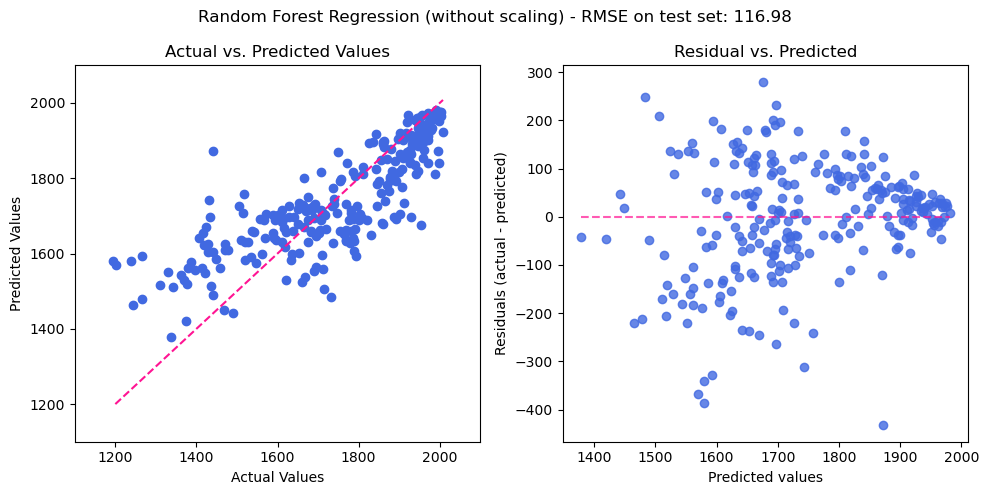

In [15]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# tnstantiate the optimized Random Forest model
rf_reg = RandomForestRegressor(n_estimators=120, min_samples_split=3, min_samples_leaf=1, n_jobs=30)

# fit the model
rf_reg_fit = rf_reg.fit(X_train_unscaled, y_train_unscaled)

# predict the y values
y_pred_rf = rf_reg_fit.predict(X_test_unscaled)

# calculate RMSE
RMSE_rf = root_mean_squared_error(y_test_unscaled, y_pred_rf)

# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for pred, actual in zip(y_test_unscaled, y_pred_rf):
    ax[0].scatter(pred, actual, color="royalblue")

# plotting the diagonal line
max_val = max(max(y_test_unscaled), max(y_pred_rf))
ax[0].plot([1200, max_val], [1200, max_val], color="deeppink", linestyle="--")

# labeling and legends
ax[0].set_ylabel("Predicted Values")
ax[0].set_xlabel("Actual Values")
ax[0].set_title("Actual vs. Predicted Values")
ax[0].set_xlim(1100, 2100)
ax[0].set_ylim(1100, 2100)

# plot the predicted y values vs the residuals
ped_plot = PredictionErrorDisplay.from_predictions(
    y_true=y_test_unscaled, 
    y_pred=y_pred_rf, 
    kind="residual_vs_predicted", 
    ax=ax[1],
    scatter_kwargs={"color": "royalblue"},
    line_kwargs={"color": "deeppink", "linestyle": "--"}
)
ax[1].set_title("Residual vs. Predicted")

plt.suptitle(f"Random Forest Regression (without scaling) - RMSE on test set: {RMSE_rf:.2f}")
plt.grid(False)
plt.tight_layout()
plt.show()


**Permutation importance**

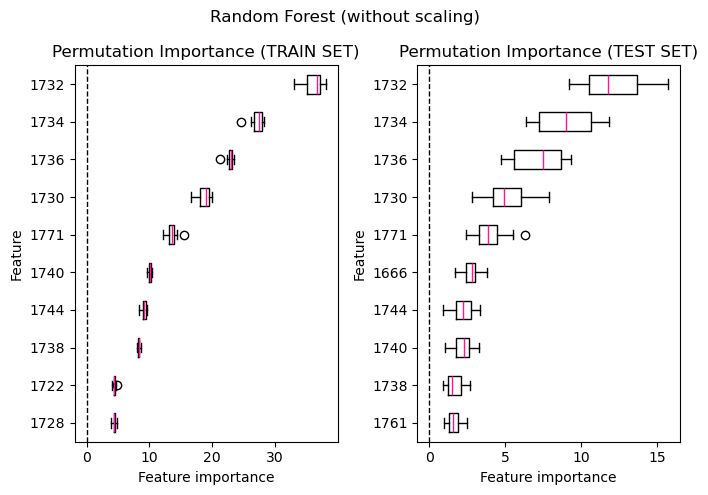

In [18]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# instantiate the optimized Random Forest model
rf_reg = RandomForestRegressor(n_estimators=120, min_samples_split=3, min_samples_leaf=1, n_jobs=30)

# fit the model
rf_reg_fit = rf_reg.fit(X_train_unscaled, y_train_unscaled)

# feature importance and permutation importance
result_train = permutation_importance(rf_reg_fit, X_train_unscaled, y_train_unscaled, n_repeats=10, random_state=42, n_jobs=30, scoring='neg_root_mean_squared_error')
result_test = permutation_importance(rf_reg_fit, X_test_unscaled, y_test_unscaled, n_repeats=10, random_state=42, n_jobs=30, scoring='neg_root_mean_squared_error')

# Plot
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

# permutation importance (TRAIN SET)
perm_sorted_idx_train = result_train.importances_mean.argsort()[-10:]  # Select the indices of the 10 most important features
axs[0].boxplot(result_train.importances[perm_sorted_idx_train].T, vert=False, labels=X_train_unscaled.columns[perm_sorted_idx_train], medianprops=dict(color="deeppink"))
axs[0].axvline(0, linestyle='--', color='black', linewidth=1)
axs[0].set_title("Permutation Importance (TRAIN SET)")
axs[0].set_xlabel('Feature importance')
axs[0].set_ylabel('Feature')

# permutation importance (TEST SET)
perm_sorted_idx_test = result_test.importances_mean.argsort()[-10:]  # Select the indices of the 10 most important features
axs[1].boxplot(result_test.importances[perm_sorted_idx_test].T, vert=False, labels=X_test_unscaled.columns[perm_sorted_idx_test], medianprops=dict(color="deeppink"))
axs[1].axvline(0, linestyle='--', color='black', linewidth=1)
axs[1].set_title("Permutation Importance (TEST SET)")
axs[1].set_xlabel('Feature importance')
axs[1].set_ylabel('Feature')

fig.suptitle("Random Forest (without scaling)")
plt.tight_layout()
plt.show()


#### Support Vector Regression (without scaling)

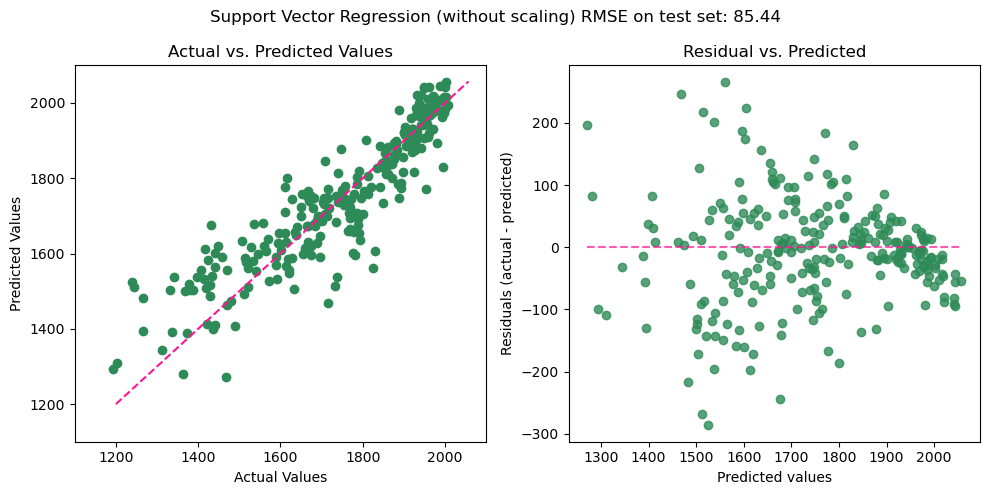

In [16]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# instantiate the optimized SVR model
SVR_reg = SVR(kernel = "rbf", gamma = "scale", C = 10000000.0, epsilon = 0.15)

# fit the model
SVR_reg_fit = SVR_reg.fit(X_train_unscaled, y_train_unscaled)

# predict the y values
y_pred_SVR = SVR_reg_fit.predict(X_test_unscaled)

# calculate RMSE
RMSE_svr = root_mean_squared_error(y_test_unscaled, y_pred_SVR)

# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for pred, actual in zip(y_test_unscaled, y_pred_SVR):
    ax[0].scatter(pred, actual, color="seagreen")

# plotting the diagonal line
max_val = max(max(y_test_unscaled), max(y_pred_SVR))
ax[0].plot([1200, max_val], [1200, max_val], color="deeppink", linestyle="--")

# labeling and legends
ax[0].set_ylabel("Predicted Values")
ax[0].set_xlabel("Actual Values")
ax[0].set_title("Actual vs. Predicted Values")
ax[0].set_xlim(1100, 2100)
ax[0].set_ylim(1100, 2100)

# plot the predicted y values vs the residuals
ped_plot = PredictionErrorDisplay.from_predictions(
    y_true=y_test_unscaled, 
    y_pred=y_pred_SVR, 
    kind="residual_vs_predicted", 
    ax=ax[1],
    scatter_kwargs={"color": "seagreen"},
    line_kwargs={"color": "deeppink", "linestyle": "--"}
)
ax[1].set_title("Residual vs. Predicted")

plt.suptitle(f"Support Vector Regression (without scaling) RMSE on test set: {RMSE_svr:.2f}")
plt.grid(False)
plt.tight_layout()
plt.show()


**Permutation importance**

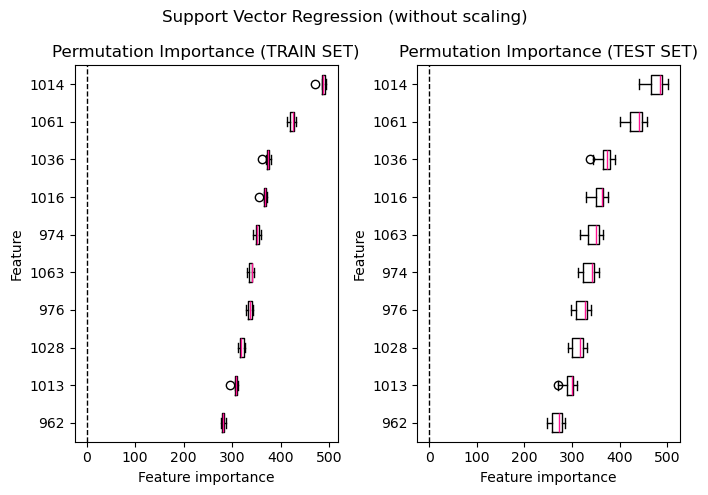

In [19]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# instantiate the optimized SVR model
SVR_reg = SVR(kernel = "rbf", gamma = "scale", C = 10000000.0, epsilon = 0.15)

# fit the model
SVR_reg_fit = SVR_reg.fit(X_train_unscaled, y_train_unscaled)

# feature importance and permutation importance
result_train = permutation_importance(SVR_reg_fit, X_train_unscaled, y_train_unscaled, n_repeats=10, random_state=42, n_jobs=30, scoring='neg_root_mean_squared_error')
result_test = permutation_importance(SVR_reg_fit, X_test_unscaled, y_test_unscaled, n_repeats=10, random_state=42, n_jobs=30, scoring='neg_root_mean_squared_error')

# Plot
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

# permutation importance (TRAIN SET)
perm_sorted_idx_train = result_train.importances_mean.argsort()[-10:]  # Select the indices of the 10 most important features
axs[0].boxplot(result_train.importances[perm_sorted_idx_train].T, vert=False, labels=X_train_unscaled.columns[perm_sorted_idx_train], medianprops=dict(color="deeppink"))
axs[0].axvline(0, linestyle='--', color='black', linewidth=1)
axs[0].set_title("Permutation Importance (TRAIN SET)")
axs[0].set_xlabel('Feature importance')
axs[0].set_ylabel('Feature')

# permutation importance (TEST SET)
perm_sorted_idx_test = result_test.importances_mean.argsort()[-10:]  # Select the indices of the 10 most important features
axs[1].boxplot(result_test.importances[perm_sorted_idx_test].T, vert=False, labels=X_test_unscaled.columns[perm_sorted_idx_test], medianprops=dict(color="deeppink"))
axs[1].axvline(0, linestyle='--', color='black', linewidth=1)
axs[1].set_title("Permutation Importance (TEST SET)")
axs[1].set_xlabel('Feature importance')
axs[1].set_ylabel('Feature')

fig.suptitle("Support Vector Regression (without scaling)")
plt.tight_layout()
plt.show()

### With scaling

In [20]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# initial training data
X_train_unscaled = deepcopy(X_TRAIN)
y_train = deepcopy(y_TRAIN)

# test data
X_test_unscaled = deepcopy(X_TEST)
y_test = deepcopy(y_TEST)

# SCALING OF DATA!
# instantiate StandardScaler
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train_unscaled)

# transform the training data
X_train_scaled = scaler.transform(X_train_unscaled)

# transform the test data
X_test_scaled = scaler.transform(X_test_unscaled)

#### Random Forest Regression (with scaling)

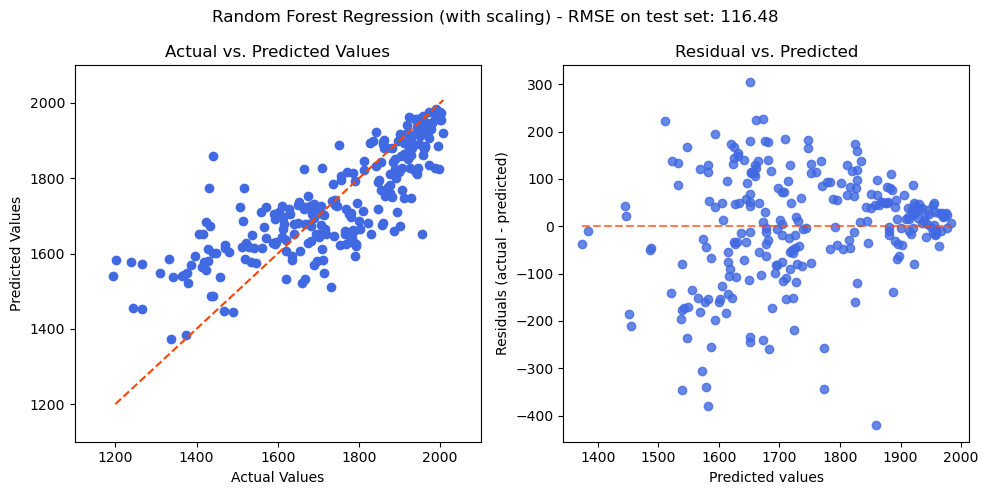

In [18]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# instantiate the optimized Random Forest model
rf_reg_s = RandomForestRegressor(n_estimators=150, min_samples_split=3, min_samples_leaf=1, n_jobs=30)

# fit the model
rf_reg_s_fit = rf_reg_s.fit(X_train_scaled, y_train)

# predict the y values
y_pred_rf_s = rf_reg_s_fit.predict(X_test_scaled)

# calculate RMSE
RMSE_rf_s = root_mean_squared_error(y_test, y_pred_rf_s)

# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for pred, actual in zip(y_test, y_pred_rf_s):
    ax[0].scatter(pred, actual, color="royalblue")

# plotting the diagonal line
max_val = max(max(y_test), max(y_pred_rf_s))
ax[0].plot([1200, max_val], [1200, max_val], color="orangered", linestyle="--")

# labeling and legends
ax[0].set_ylabel("Predicted Values")
ax[0].set_xlabel("Actual Values")
ax[0].set_title("Actual vs. Predicted Values")
ax[0].set_xlim(1100, 2100)
ax[0].set_ylim(1100, 2100)

# plot the predicted y values vs the residuals
ped_plot = PredictionErrorDisplay.from_predictions(
    y_true=y_test, 
    y_pred=y_pred_rf_s, 
    kind="residual_vs_predicted", 
    ax=ax[1],
    scatter_kwargs={"color": "royalblue"},
    line_kwargs={"color": "orangered", "linestyle": "--"}
)
ax[1].set_title("Residual vs. Predicted")

plt.suptitle(f"Random Forest Regression (with scaling) - RMSE on test set: {RMSE_rf_s:.2f}")
plt.grid(False)
plt.tight_layout()
plt.show()

**Permutation importance**

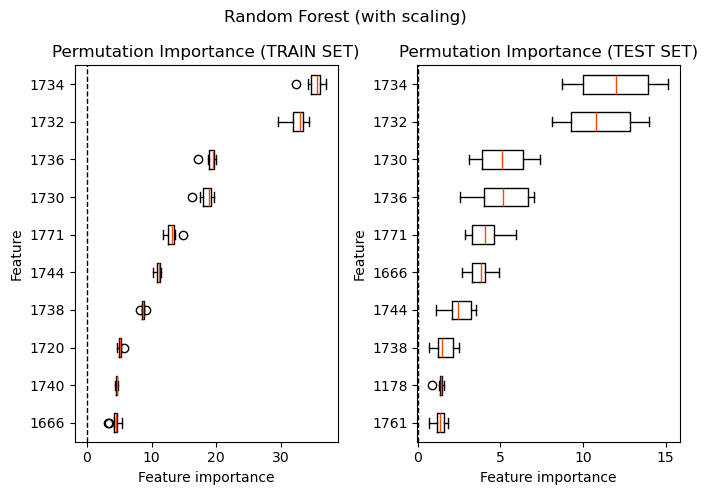

In [21]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# change to pandas dataframe (due to different data type after scaling)
X_train_scaled_pd = pd.DataFrame(X_train_scaled, columns = X_train_unscaled.columns)
X_test_scaled_pd = pd.DataFrame(X_test_scaled, columns = X_test_unscaled.columns)

# instantiate the optimized RF model
rf_reg_s = RandomForestRegressor(n_estimators=150, min_samples_split=3, min_samples_leaf=1, n_jobs=30)

# fit the model
rf_reg_s_fit = rf_reg_s.fit(X_train_scaled_pd, y_train)

# feature importance and permutation importance
result_train = permutation_importance(rf_reg_s_fit, X_train_scaled_pd, y_train, n_repeats=10, random_state=42, n_jobs=30, scoring='neg_root_mean_squared_error')
result_test = permutation_importance(rf_reg_s_fit, X_test_scaled_pd, y_test, n_repeats=10, random_state=42, n_jobs=30, scoring='neg_root_mean_squared_error')

# Plot
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

# permutation importance (TRAIN SET)
perm_sorted_idx_train = result_train.importances_mean.argsort()[-10:]  # Select the indices of the 10 most important features
axs[0].boxplot(result_train.importances[perm_sorted_idx_train].T, vert=False, labels=X_train_scaled_pd.columns[perm_sorted_idx_train], medianprops=dict(color="orangered"))
axs[0].axvline(0, linestyle='--', color='black', linewidth=1)
axs[0].set_title("Permutation Importance (TRAIN SET)")
axs[0].set_xlabel('Feature importance')
axs[0].set_ylabel('Feature')

# permutation importance (TEST SET)
perm_sorted_idx_test = result_test.importances_mean.argsort()[-10:]  # Select the indices of the 10 most important features
axs[1].boxplot(result_test.importances[perm_sorted_idx_test].T, vert=False, labels=X_test_scaled_pd.columns[perm_sorted_idx_test], medianprops=dict(color="orangered"))
axs[1].axvline(0, linestyle='--', color='black', linewidth=1)
axs[1].set_title("Permutation Importance (TEST SET)")
axs[1].set_xlabel('Feature importance')
axs[1].set_ylabel('Feature')

fig.suptitle("Random Forest (with scaling)")
plt.tight_layout()
plt.show()

#### Support Vector Regression (with scaling)

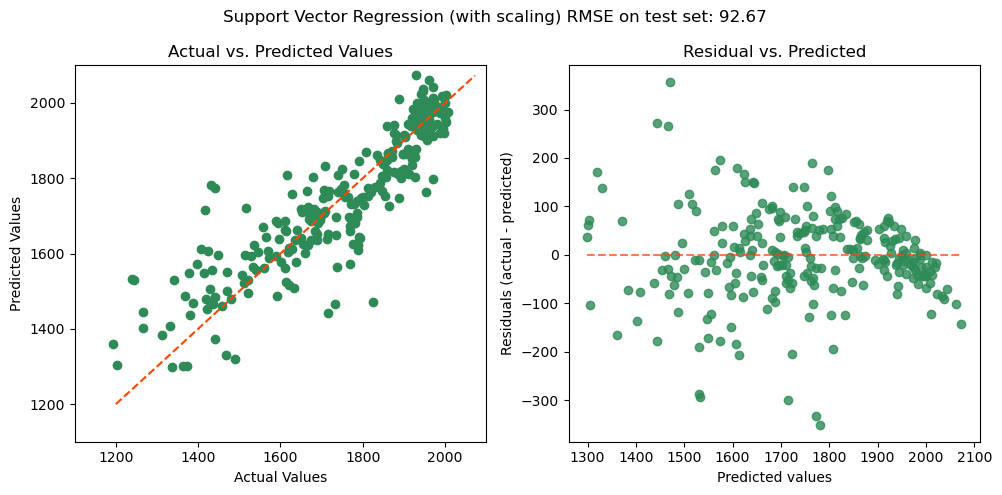

In [22]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# instantiate the optimized SVR model
SVR_reg_s = SVR(kernel = "rbf", gamma = "scale", C = 6000.0, epsilon = 12.5)

# fit the model
SVR_reg_s_fit = SVR_reg_s.fit(X_train_scaled, y_train)

# predict data
y_pred_SVR_s = SVR_reg_s_fit.predict(X_test_scaled)

# calculate RMSE
RMSE_svr_s = root_mean_squared_error(y_test, y_pred_SVR_s)

# PLOT SECTION
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for pred, actual in zip(y_test, y_pred_SVR_s):
    ax[0].scatter(pred, actual, color="seagreen")

# plotting the diagonal line
max_val = max(max(y_test), max(y_pred_SVR_s))
ax[0].plot([1200, max_val], [1200, max_val], color="orangered", linestyle="--")

# labeling and legends
ax[0].set_ylabel("Predicted Values")
ax[0].set_xlabel("Actual Values")
ax[0].set_title("Actual vs. Predicted Values")
ax[0].set_xlim(1100, 2100)
ax[0].set_ylim(1100, 2100)

# plot the predicted y values vs the residuals
ped_plot = PredictionErrorDisplay.from_predictions(
    y_true=y_test, 
    y_pred=y_pred_SVR_s, 
    kind="residual_vs_predicted", 
    ax=ax[1],
    scatter_kwargs={"color": "seagreen"},
    line_kwargs={"color": "orangered", "linestyle": "--"}
)
ax[1].set_title("Residual vs. Predicted")

plt.suptitle(f"Support Vector Regression (with scaling) RMSE on test set: {RMSE_svr_s:.2f}")
plt.grid(False)
plt.tight_layout()
plt.show()

**Permutation importance**

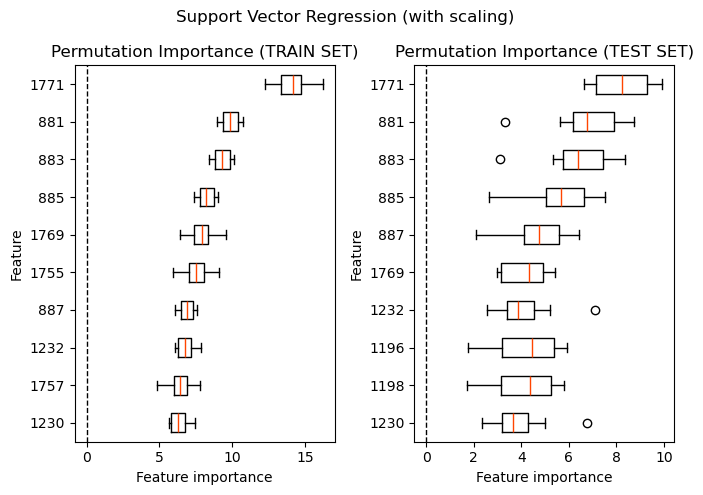

In [23]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# change to pandas dataframe (due to different data type after scaling)
X_train_scaled_pd = pd.DataFrame(X_train_scaled, columns = X_train_unscaled.columns)
X_test_scaled_pd = pd.DataFrame(X_test_scaled, columns = X_test_unscaled.columns)

# instantiate the optimized SVR model
SVR_reg_s = SVR(kernel = "rbf", gamma = "scale", C = 6000.0, epsilon = 12.5)

# fit the model
SVR_reg_s_fit = SVR_reg_s.fit(X_train_scaled_pd, y_train)

# feature importance and permutation importance
result_train = permutation_importance(SVR_reg_s_fit, X_train_scaled_pd, y_train, n_repeats=10, random_state=42, n_jobs=30, scoring='neg_root_mean_squared_error')
result_test = permutation_importance(SVR_reg_s_fit, X_test_scaled_pd, y_test, n_repeats=10, random_state=42, n_jobs=30, scoring='neg_root_mean_squared_error')

# Plot
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

# permutation importance (TRAIN SET)
perm_sorted_idx_train = result_train.importances_mean.argsort()[-10:]  # Select the indices of the 10 most important features
axs[0].boxplot(result_train.importances[perm_sorted_idx_train].T, vert=False, labels=X_train_scaled_pd.columns[perm_sorted_idx_train], medianprops=dict(color="orangered"))
axs[0].axvline(0, linestyle='--', color='black', linewidth=1)
axs[0].set_title("Permutation Importance (TRAIN SET)")
axs[0].set_xlabel('Feature importance')
axs[0].set_ylabel('Feature')

# permutation importance (TEST SET)
perm_sorted_idx_test = result_test.importances_mean.argsort()[-10:]  # Select the indices of the 10 most important features
axs[1].boxplot(result_test.importances[perm_sorted_idx_test].T, vert=False, labels=X_test_scaled_pd.columns[perm_sorted_idx_test], medianprops=dict(color="orangered"))
axs[1].axvline(0, linestyle='--', color='black', linewidth=1)
axs[1].set_title("Permutation Importance (TEST SET)")
axs[1].set_xlabel('Feature importance')
axs[1].set_ylabel('Feature')

fig.suptitle("Support Vector Regression (with scaling)")
plt.tight_layout()
plt.show()